## Setup

In [1]:
!pip install -Uq fastai timm

In [2]:
from fastai.vision.all import *

path = untar_data(URLs.PASCAL_2007)
path.ls()

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


(#8) [Path('/root/.fastai/data/pascal_2007/test.json'),Path('/root/.fastai/data/pascal_2007/train.csv'),Path('/root/.fastai/data/pascal_2007/test'),Path('/root/.fastai/data/pascal_2007/valid.json'),Path('/root/.fastai/data/pascal_2007/train'),Path('/root/.fastai/data/pascal_2007/test.csv'),Path('/root/.fastai/data/pascal_2007/segmentation'),Path('/root/.fastai/data/pascal_2007/train.json')]

## Check and load Data 

In [3]:
trn_path = path/'train'
files = get_image_files(trn_path)

(500, 375)


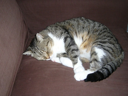

In [4]:
img = PILImage.create(files[0])
print(img.size)
img.to_thumb(128)

In [5]:
df = pd.read_csv(path/'train.csv')
df.head()

,fname,labels,is_valid
0,000005.jpg,chair,True
1,000007.jpg,car,True
2,000009.jpg,horse person,True
3,000012.jpg,car,False
4,000016.jpg,bicycle,True


In [6]:
dls = ImageDataLoaders.from_df(df, path, folder='train', valid_col='is_valid', label_delim=' ',
                               item_tfms=Resize(460), batch_tfms=aug_transforms(size=224))

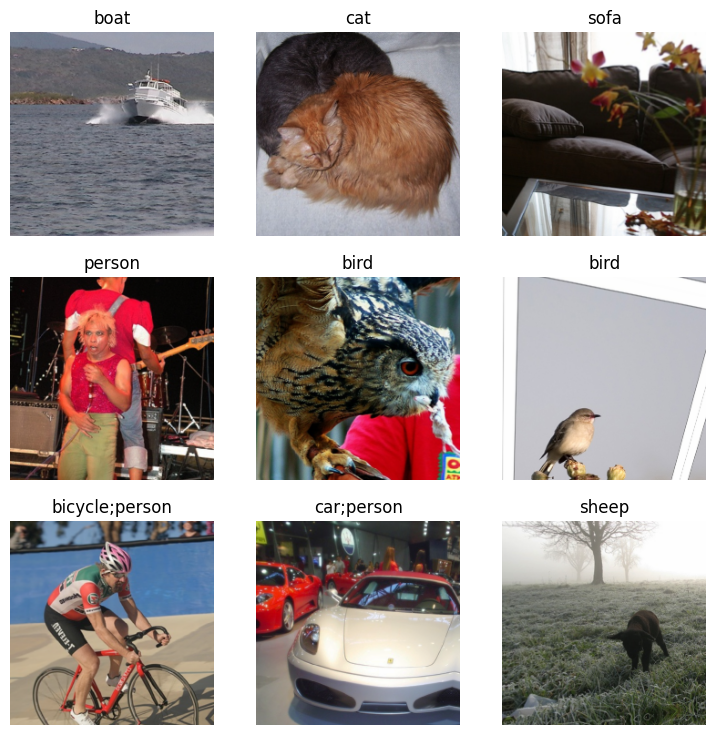

In [7]:
dls.show_batch()

## Train

In [8]:
f1_macro = F1ScoreMulti(thresh=0.5, average='macro')
f1_macro.name = 'F1(macro)'
f1_samples = F1ScoreMulti(thresh=0.5, average='samples')
f1_samples.name = 'F1(samples)'
learn = vision_learner(dls, resnet50, metrics=[partial(accuracy_multi, thresh=0.5), f1_macro, f1_samples])

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:02<00:00, 43.5MB/s]


SuggestedLRs(valley=0.0014454397605732083, slide=0.013182567432522774)

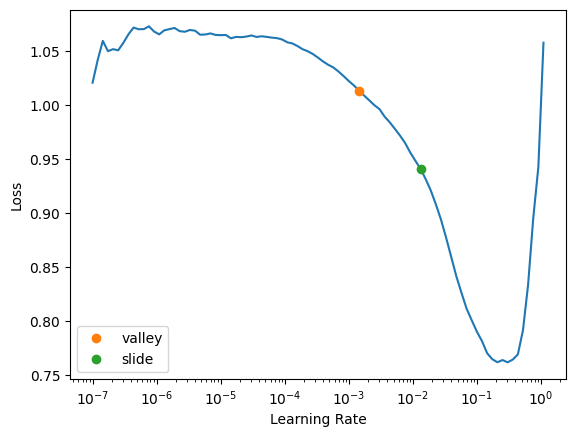

In [9]:
learn.lr_find(suggest_funcs=(valley, slide))

In [10]:
learn.fine_tune(4, 3e-2)

epoch,train_loss,valid_loss,accuracy_multi,F1(macro),F1(samples),time
0,0.432325,0.113454,0.964024,0.731120,0.767213,00:56


epoch,train_loss,valid_loss,accuracy_multi,F1(macro),F1(samples),time
0,0.160436,0.983216,0.921952,0.202728,0.379673,00:57
1,0.168536,0.427847,0.925299,0.333517,0.419319,00:56
2,0.150563,0.123792,0.956335,0.602621,0.629697,00:58
3,0.124403,0.110310,0.960498,0.641118,0.669878,00:58


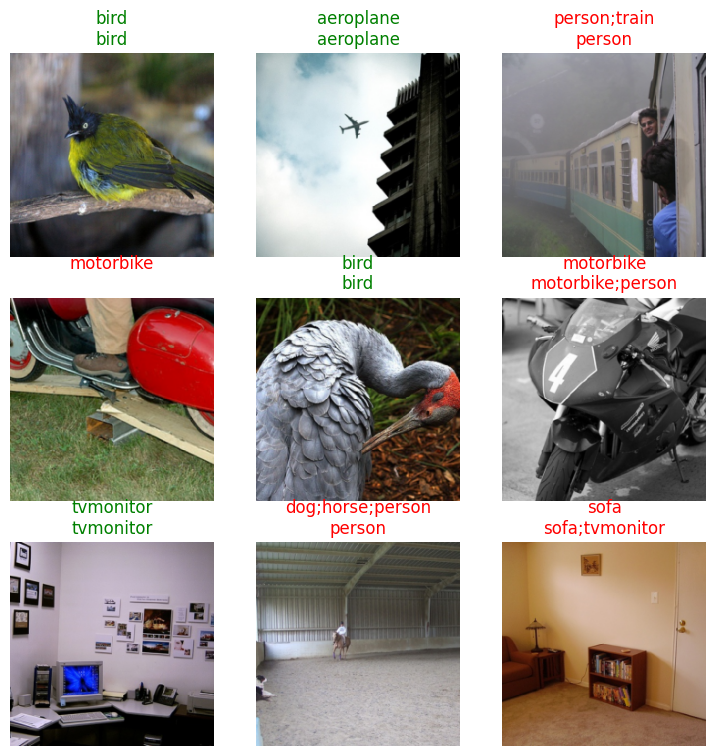

In [11]:
learn.show_results()

## Evaluation

In [12]:
learn.predict(path/'train/000005.jpg')

((#1) ['chair'],
 tensor([False, False, False, False, False, False, False, False,  True, False,
         False, False, False, False, False, False, False, False, False, False]),
 tensor([1.4458e-03, 3.3114e-03, 3.0184e-04, 3.5807e-03, 1.0120e-02, 1.1847e-03,
         4.2280e-03, 1.4208e-03, 9.4552e-01, 1.0103e-03, 3.1197e-01, 1.2744e-02,
         5.8863e-04, 3.5371e-04, 5.7732e-02, 1.4418e-01, 6.8431e-05, 3.0569e-01,
         5.2905e-03, 1.8817e-01]))

/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


,target,predicted,probabilities,loss
0,car;person;tvmonitor,car,"tensor([9.2121e-13, 1.9588e-06, 9.6515e-13, 4.5564e-12, 2.4089e-06, 2.0140e-06,\n 9.9998e-01, 1.0254e-10, 1.6285e-06, 1.2077e-15, 6.4983e-07, 2.5158e-08,\n 4.0794e-17, 4.7168e-07, 7.5833e-02, 7.0555e-04, 3.4122e-12, 1.8839e-09,\n 8.1568e-13, 3.0306e-12])",1.4551112651824951
1,bus,person,"tensor([8.3319e-19, 4.1313e-10, 5.3701e-19, 1.1874e-21, 8.5710e-07, 1.2771e-07,\n 3.7117e-01, 1.4059e-16, 7.8097e-06, 1.2801e-20, 3.3562e-06, 8.9919e-10,\n 1.3279e-24, 1.6093e-10, 9.9929e-01, 1.1677e-04, 1.1030e-16, 3.9992e-13,\n 1.3150e-19, 3.5234e-21])",1.1791664361953735
2,bus;person,person,"tensor([2.1743e-25, 1.3167e-12, 4.7575e-25, 8.4788e-30, 6.5007e-07, 1.0600e-10,\n 6.9854e-03, 9.0411e-22, 4.6634e-06, 6.8995e-28, 6.9209e-07, 4.8713e-12,\n 9.9537e-33, 9.5837e-15, 1.0000e+00, 1.2631e-05, 8.0718e-22, 1.5875e-16,\n 2.1325e-27, 4.5667e-27])",1.148730754852295
3,bus;car,car,"tensor([2.6460e-17, 8.6411e-08, 1.6966e-17, 3.0391e-17, 7.1335e-08, 2.2705e-08,\n 1.0000e+00, 1.8735e-14, 2.8500e-07, 1.4781e-21, 3.8427e-08, 1.9449e-10,\n 2.3475e-23, 3.0946e-10, 6.0827e-02, 1.1054e-04, 9.8694e-17, 4.4687e-12,\n 2.6127e-18, 1.1181e-16])",0.8831769824028015
4,dog,cat,"tensor([6.3184e-07, 2.3657e-06, 1.4482e-05, 3.6702e-06, 2.1129e-04, 4.9073e-06,\n 4.4872e-06, 9.9961e-01, 5.4511e-04, 1.9418e-06, 8.2063e-06, 4.2967e-04,\n 2.9915e-05, 1.0739e-07, 3.3795e-04, 3.8352e-05, 3.0476e-05, 4.7639e-04,\n 4.3233e-08, 9.6770e-05])",0.7807657122612
5,bird;cow,dog,"tensor([3.5085e-05, 1.7869e-04, 1.7604e-04, 2.5363e-04, 3.7888e-04, 7.0829e-04,\n 5.3927e-03, 3.7318e-03, 2.7866e-03, 5.1422e-02, 4.6965e-04, 9.3140e-01,\n 7.5663e-03, 4.6385e-04, 1.0814e-01, 4.8316e-04, 5.3608e-03, 3.2117e-02,\n 7.8627e-06, 2.6671e-04])",0.723357617855072
6,chair;diningtable;person,person;train,"tensor([2.9290e-04, 1.4542e-02, 3.2323e-04, 8.2901e-04, 5.1153e-04, 1.5296e-01,\n 7.0044e-02, 2.9667e-04, 2.5125e-03, 3.2945e-03, 2.0932e-03, 3.0326e-04,\n 5.6329e-03, 3.1153e-02, 8.6642e-01, 5.6824e-03, 2.0222e-04, 5.0289e-04,\n 8.1174e-01, 3.4916e-04])",0.7136017680168152
7,horse;person,bird,"tensor([1.6349e-03, 1.9673e-03, 6.3605e-01, 3.1123e-03, 4.4924e-04, 2.7758e-03,\n 2.3528e-02, 1.1137e-03, 7.7601e-03, 1.4924e-03, 8.1832e-04, 1.4635e-03,\n 1.5093e-03, 7.9470e-05, 5.4518e-03, 4.7021e-01, 1.0804e-03, 3.4701e-04,\n 7.8731e-04, 3.7700e-04])",0.6701523661613464
8,bus;person,car,"tensor([3.0906e-05, 2.2279e-03, 1.1572e-05, 5.7400e-04, 3.2200e-04, 7.9000e-03,\n 9.9715e-01, 4.9984e-05, 1.5319e-03, 1.5893e-06, 1.4940e-04, 4.8800e-05,\n 9.5120e-07, 1.6508e-04, 1.0650e-01, 1.0046e-02, 1.3239e-05, 5.6107e-04,\n 2.2403e-03, 4.1991e-04])",0.6479545831680298


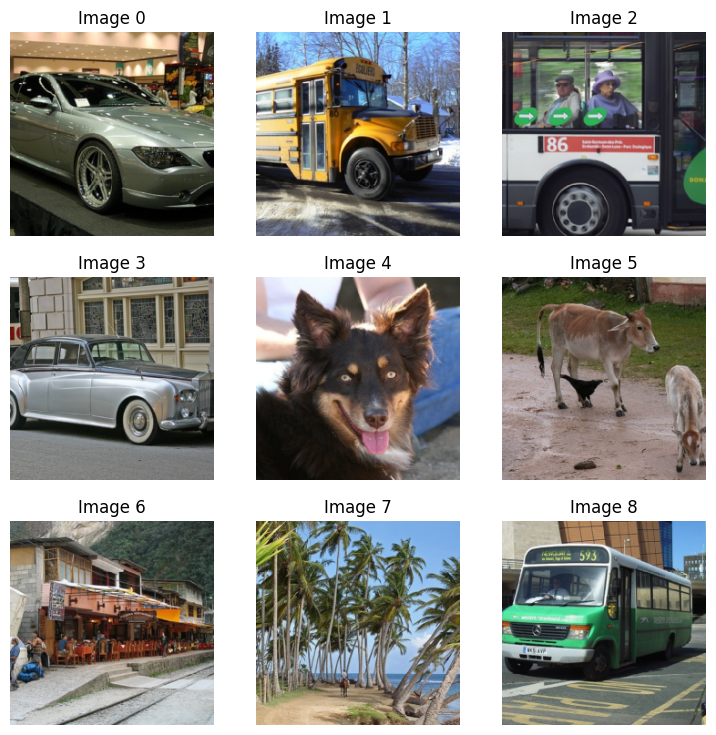

In [13]:
interp = Interpretation.from_learner(learn)
interp.plot_top_losses(9)

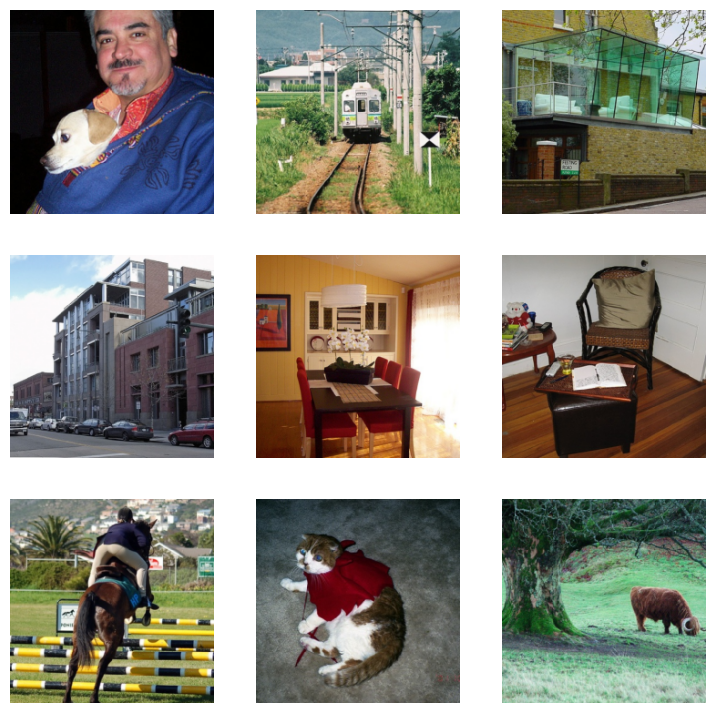

In [21]:
tst_files = get_image_files(path/'test').sorted()
tst_dl = dls.test_dl(tst_files)
tst_dl.show_batch()

In [15]:
tst_df = pd.read_csv(path/'test.csv')
tst_df.head()

,fname,labels
0,000001.jpg,dog person
1,000002.jpg,train
2,000003.jpg,sofa chair
3,000004.jpg,car
4,000006.jpg,pottedplant diningtable chair


In [16]:
learn.predict(path/'test/000001.jpg')

((#2) ['dog','person'],
 tensor([False, False, False, False, False, False, False, False, False, False,
         False,  True, False, False,  True, False, False, False, False, False]),
 tensor([3.7534e-04, 3.3068e-03, 3.5333e-03, 1.4646e-03, 1.6098e-02, 9.2316e-03,
         9.2683e-03, 1.2430e-02, 3.5616e-02, 3.9120e-03, 6.5138e-03, 5.7729e-01,
         1.0427e-02, 3.5343e-03, 9.8205e-01, 4.2955e-03, 2.6792e-03, 7.8348e-02,
         1.2716e-03, 1.4428e-02]))

In [23]:
probs,_,decoded = learn.get_preds(dl=tst_dl, with_decoded=True)
probs,_,decoded

(tensor([[3.7534e-04, 3.3068e-03, 3.5333e-03,  ..., 7.8348e-02, 1.2716e-03,
          1.4428e-02],
         [6.2719e-03, 2.6230e-02, 6.1860e-03,  ..., 3.0601e-03, 5.5415e-01,
          5.2159e-03],
         [1.6954e-03, 1.4680e-02, 3.4611e-03,  ..., 4.5639e-02, 3.1375e-02,
          4.8553e-02],
         ...,
         [7.1728e-04, 4.2148e-03, 4.1409e-03,  ..., 1.7086e-03, 1.9871e-04,
          8.6617e-04],
         [4.4875e-04, 5.7884e-03, 3.2388e-03,  ..., 2.5351e-02, 1.9772e-03,
          7.9003e-03],
         [4.2774e-03, 4.9385e-03, 7.4125e-03,  ..., 1.3231e-02, 6.1573e-02,
          2.0687e-02]]),
 None,
 tensor([[False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False,  True, False],
         [False, False, False,  ..., False, False, False],
         ...,
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False]]))

In [18]:
dls.vocab

['aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus', 'car', 'cat', 'chair', 'cow', 'diningtable', 'dog', 'horse', 'motorbike', 'person', 'pottedplant', 'sheep', 'sofa', 'train', 'tvmonitor']

In [49]:
result_dict = {}

# Iterate through each row in the tensor
for i, row in enumerate(decoded):
    mapped_labels = [dls.vocab[j] for j, value in enumerate(row) if value]
    result_dict[i] = " ".join(mapped_labels)
    
result_df = pd.DataFrame.from_dict(result_dict, orient='index', columns=['pred'])
result_df["labels"] = tst_df["labels"]
result_df

,pred,labels
0,dog person,dog person
1,train,train
2,,sofa chair
3,car,car
4,chair sofa,pottedplant diningtable chair
...,...,...
4947,cat,cat
4948,horse person,person horse
4949,motorbike person,motorbike person
4950,person,chair person diningtable
